In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import spearmanr

import scvelo as scv
import scanpy as sc
import anndata as an
import scvi
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

# Load expression

In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle_velocity.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 543 ms, sys: 1.9 s, total: 2.45 s
Wall time: 4.73 s


AnnData object with n_obs × n_vars = 7541 × 21412
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_

In [3]:
%%time
before = adata.shape[0]

sc.pp.filter_cells(adata, min_counts=8000)
sc.pp.filter_genes(adata, min_counts=50)

after = adata.shape[0]
filtered = before - after

print(f"Cells before filtering: {before}")
print(f"Cells after filtering:  {after}")
print(f"Cells filtered out:     {filtered}")

adata

Cells before filtering: 7541
Cells after filtering:  6895
Cells filtered out:     646
CPU times: user 2.48 s, sys: 3.31 s, total: 5.79 s
Wall time: 5.81 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 69/500:  14%|█▍        | 69/500 [01:25<08:56,  1.25s/it, v_num=1, train_loss_step=9.8e+3, train_loss_epoch=9.79e+3] 
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 9837.847. Signaling Trainer to stop.


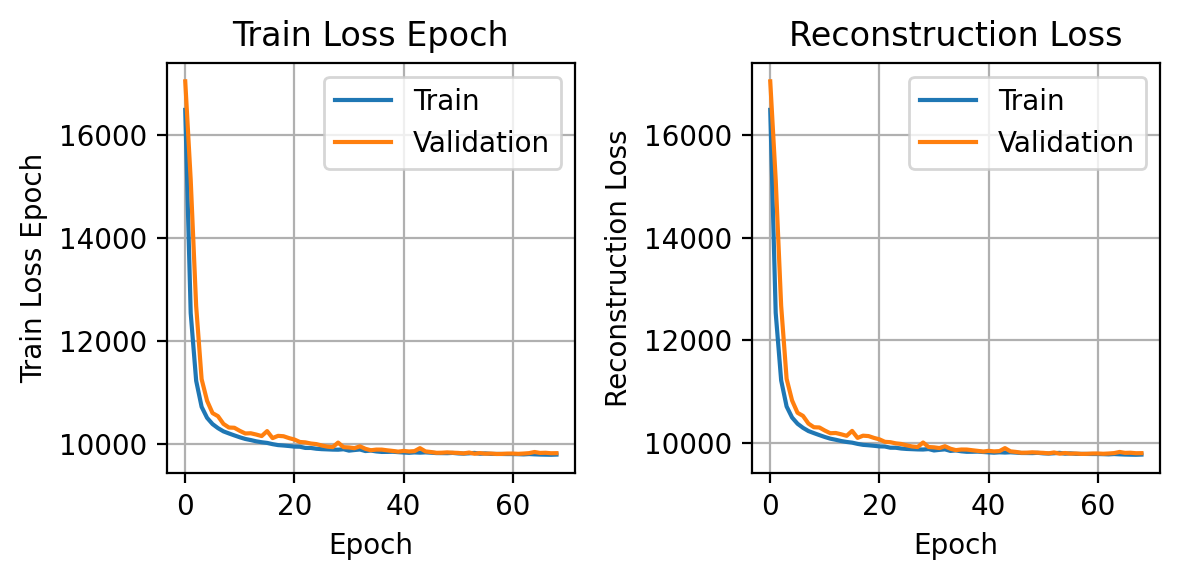

CPU times: user 43 s, sys: 44.5 s, total: 1min 27s
Wall time: 1min 27s


In [4]:
%%time
batch_key = "batch"

bdata = adata.copy()

# scvi
scvi.model.SCVI.setup_anndata(
    bdata, 
    batch_key=batch_key,
)

model = scvi.model.SCVI(
    bdata,
    n_hidden=128,
    n_latent=24,
    n_layers=2, 
    dispersion='gene-cell',
    gene_likelihood='zinb',
)

model.train(
    max_epochs=500,
    accelerator='gpu',
    early_stopping_patience=10,
    early_stopping=True,
    batch_size=500,
    plan_kwargs={"lr": 1e-3},
)

history = model.history

metrics = [
    ("train_loss_epoch", "validation_loss"),
    ("reconstruction_loss_train", "reconstruction_loss_validation"),
]

plt.rcParams['figure.dpi'] = 200
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.flatten()

for i, (train_key, val_key) in enumerate(metrics):
    ax = axes[i]
    train_df = history[train_key]
    val_df = history[val_key]

    ax.plot(train_df.index, train_df[train_key], label='Train')
    ax.plot(val_df.index, val_df[val_key], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(train_key.replace('_train', '').replace('_', ' ').title())
    ax.set_title(train_key.replace('_train', '').replace('_', ' ').title())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Generate Embeddings

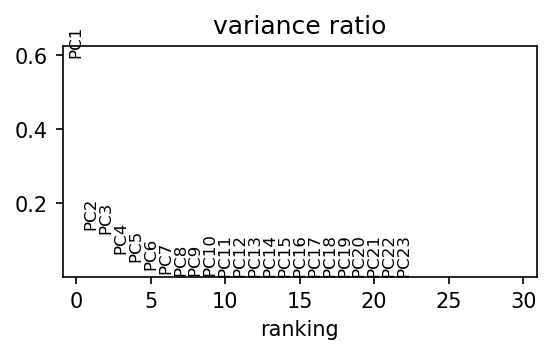

embed.obs["leiden"].nunique()=6
                   phase leiden cluster_phase
AAACCAAAGGGTAGCA-1   G2M      2             S
AAACCAAAGTAAGGGT-1    G1      0            G1
AAACCATTCAGGTAGG-1   G2M      1           G2M
AAACCATTCCAGCCCT-1    G1      0            G1
AAACCATTCGTGACCG-1    G1      0            G1


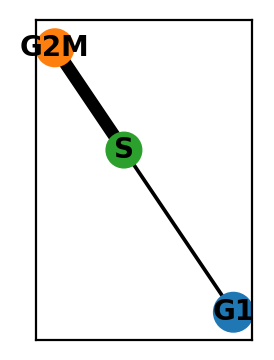

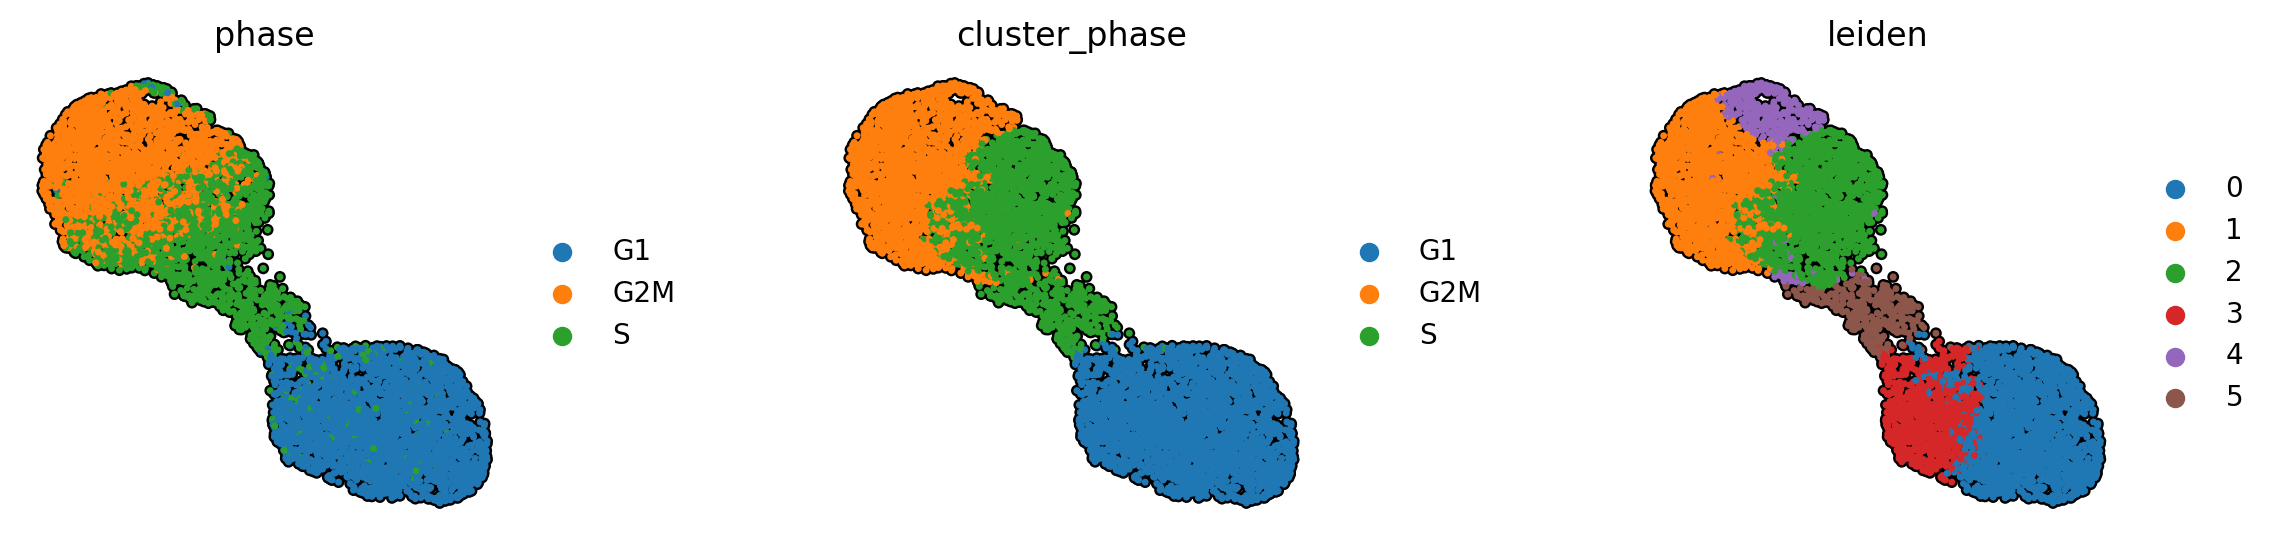

CPU times: user 40.8 s, sys: 717 ms, total: 41.5 s
Wall time: 40.7 s


In [5]:
%%time 

n_neighbors = 75
n_pcs = 24
resolution = 0.45
min_dist = 0.2
paga_groups = 'phase'


embed = model.get_latent_representation()
embed = sc.AnnData(embed, obs=adata.obs)

sc.pp.pca(embed)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4, 2
sc.pl.pca_variance_ratio(embed)

sc.pp.neighbors(embed, n_pcs=n_pcs, n_neighbors=n_neighbors)
sc.tl.leiden(embed, resolution=resolution)
print(f"{embed.obs["leiden"].nunique()=}")

# find most frequent phase per leiden cluster
mode_map = (
    embed.obs.groupby("leiden")["phase"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# assign to new column
embed.obs["cluster_phase"] = embed.obs["leiden"].map(mode_map)
print(embed.obs[['phase', 'leiden', 'cluster_phase']].head().to_string())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2
sc.tl.paga(embed, groups=paga_groups)
sc.pl.paga(embed)
sc.tl.umap(embed, min_dist=min_dist, init_pos='paga')

palette = {
    "G1": "#D73027",        
    "S": "#FDAE61",       
    "G2M": "#1A9850",    
    "unknown": "#B0B0B0", 
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    embed,
    color=['phase', 'cluster_phase', 'leiden'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

# Get Imputed Expression

In [6]:
%%time
X = model.get_normalized_expression(library_size=1e6)

# make sure the index matches adata.obs index
X = X.loc[adata.obs.index]
X = X[adata.var.index]

# add to adata
adata.obs['leiden'] = embed.obs['leiden'].copy()
adata.obs['cluster_phase'] = embed.obs['cluster_phase'].copy()
adata.layers['scvi'] = X.copy()
adata.obsm['X_umap'] = embed.obsm['X_umap'].copy()
adata.obsm['X_scvi'] = embed.X.copy()

adata

CPU times: user 2.23 s, sys: 1.05 s, total: 3.28 s
Wall time: 2.53 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_

# MAGIC

In [7]:
%%time
magic = sc.external.pp.magic(
    adata,
    knn=20,
    solver='approximate',
    verbose=True,
    copy=True,
)

adata.layers['X_magic'] = magic.X.copy()
adata

Calculating MAGIC...
  Running MAGIC on 6895 cells and 15906 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 25.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.76 seconds.
    Calculating affinities...
    Calculated affinities in 5.77 seconds.
  Calculated graph and diffusion operator in 36.58 seconds.
  Calculating imputation...
  Calculated imputation in 0.12 seconds.
Calculated MAGIC in 37.41 seconds.
CPU times: user 50.7 s, sys: 1.96 s, total: 52.6 s
Wall time: 41 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_

# Write Out

In [10]:
%%time
outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/imputed.h5ad"
adata.write(outpath)
adata

CPU times: user 1.83 s, sys: 2.33 s, total: 4.16 s
Wall time: 11.9 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_

In [ ]:
break